## Australian Rainfall Data Download and Exploratory Data Analysis

Attribution: code adapted from DSCI 525 lecture notes.

#### 1. Imports 

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
from memory_profiler import memory_usage
import pyarrow.parquet as pq
import pyarrow as pa
import pyarrow.feather as feather
import rpy2
import rpy2.rinterface
import warnings
warnings.filterwarnings('ignore')

#### 2. Downloading data using figshare API

In [2]:
# Necessary metadata
article_id = 14096681  # unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]             
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [5]:
%%time
files_to_dl = ["data.zip"]  
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 6.99 s, sys: 8.79 s, total: 15.8 s
Wall time: 2min 50s


In [6]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 17.5 s, sys: 2.52 s, total: 20.1 s
Wall time: 21.3 s


In [7]:
# remove observed_daily_rainfall.csv file from directory
file_path = 'figsharerainfall/observed_daily_rainfall_SYD.csv'
os.remove(file_path)

#### 3. Combining data files into one CSV file

In [8]:
%%time
## here we are using a normal python way for merging the data 
import pandas as pd
use_cols = ["time", "lat_min", "lat_max", "lon_min","lon_max","rain (mm/day)"]
files = glob.glob('figsharerainfall/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0, usecols=use_cols)
                .assign(model=re.findall(r"[\/|\\](.*)_daily_rainfall", file)[0])
                for file in files)
              )
df.to_csv("figsharerainfall/combined_data.csv")

CPU times: user 5min 58s, sys: 24.8 s, total: 6min 23s
Wall time: 6min 40s


In [9]:
%%sh
du -sh figsharerainfall/combined_data.csv

5.6G	figsharerainfall/combined_data.csv


In [10]:
%%time
df.head()

CPU times: user 185 µs, sys: 291 µs, total: 476 µs
Wall time: 484 µs


,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


##### 3.1 Comparing run times on different machines 

- We used pandas to concatenate the files in data.zip folder to a combined file which is `5.6GB` in size.
- The run time on different machines ranged from `6 min to 10 min` across different machines (one MacOS vs two Windows 10 operating system). The MacOS with 16GB RAM took the least time to combine the datafile into run large csv file.
- Runtime observations on group members' laptops are shown below:

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken to combine files |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arlin   |      MacOS Monterey|  16GB   | 2 GHz Quad-Core Intel Core i5          |    No    |  Total: 6 min 9s; Wall time: 6 min 20s
| Artan   |      Windows 10    |  8GB   |   1.80 GHz Intel Core i5                |    Yes    |       Total: 9min 4s; Wall time: 9min 28s      |
| Shi Yan |      Windows 10    |  8GB   |   1.50 GHz Intel Core i5                |    Yes    |       Total: 10min 23s; Wall time: 10min 11s      |


#### 4. Load the combined CSV to memory and perform a simple EDA

EDA question: Perform value counts on a float variable `lat_min`.

##### 4.1 Regular Loading

In [11]:
%%time
# Load time
df = pd.read_csv("figsharerainfall/combined_data.csv")

CPU times: user 54.3 s, sys: 22 s, total: 1min 16s
Wall time: 1min 31s


In [12]:
%%time
# Simple EDA
counts = df["lat_min"].value_counts()

CPU times: user 694 ms, sys: 488 ms, total: 1.18 s
Wall time: 1.5 s


##### 4.2 Changing Data Type

In [13]:
%%time
# Load time
df_16 = pd.read_csv("figsharerainfall/combined_data.csv", dtype={"lat_min": np.float16,
                                                              "lat_max": np.float16,
                                                              "lon_min": np.float16,  
                                                              "lon_max": np.float16,
                                                              "rain (mm/day)": np.float16})

CPU times: user 55.2 s, sys: 11 s, total: 1min 6s
Wall time: 1min 12s


In [14]:
# Comparing memory space between datatype64GB and 16GB
print(f"DataFrame with numeric columns as float16: {df_16.memory_usage().sum() / 1e6:.2f} GB")
print(f"DataFrame with numeric columns as float64: {df.memory_usage().sum() / 1e6:.2f} GB")

DataFrame with numeric columns as float16: 1624.16 GB
DataFrame with numeric columns as float64: 3498.20 GB


In [15]:
%%time
# Simple EDA
counts = df_16["lat_min"].value_counts()

CPU times: user 782 ms, sys: 208 ms, total: 990 ms
Wall time: 1.01 s


##### 4.3 Load Selected Columns Only

In [16]:
%%time
# Load time
df = pd.read_csv("figsharerainfall/combined_data.csv", usecols=["lat_min","lat_max", "rain (mm/day)"])

CPU times: user 30.9 s, sys: 10.6 s, total: 41.5 s
Wall time: 47.8 s


In [17]:
%%time
# Simple EDA
counts = df["lat_min"].value_counts()

CPU times: user 726 ms, sys: 499 ms, total: 1.22 s
Wall time: 1.53 s


##### 4.4 Loading in Chunks

In [18]:
%%time
# Load and EDA time
chunk_counts = pd.Series(dtype=np.float16)
for chunk in pd.read_csv("figsharerainfall/combined_data.csv", chunksize=10_000_000):
    chunk_counts.add(chunk["lat_min"].value_counts(), 
                     fill_value=None)  # To exclude NaN
chunk_counts.head()

CPU times: user 54.8 s, sys: 10.6 s, total: 1min 5s
Wall time: 1min 8s


Series([], dtype: float16)

##### 4.5 Loading with Dask

In [19]:
%%time
# Load time
import dask.dataframe as dd
df_dask = dd.read_csv("figsharerainfall/combined_data.csv")

CPU times: user 503 ms, sys: 513 ms, total: 1.02 s
Wall time: 1.83 s


In [20]:
%%time
#computing values of lat_min variable 
df_dask["lat_min"].value_counts().compute()

CPU times: user 38.1 s, sys: 11.6 s, total: 49.6 s
Wall time: 14.4 s


-31.099476    3035329
-32.984293    3035329
-34.869110    3035329
-32.041885    3035329
-30.000000    1747830
               ...   
-30.696652     183960
-36.277805     183960
-36.281964     183960
-30.700015     183960
-33.487232     183960
Name: lat_min, Length: 84, dtype: int64

##### 4.6 Comparing Wall Time of Different Machines

| Team Member | Task  |  Regular Loading |      Changed Data Type |      Selected Columns |  Chunks            |   Dask        |
|:-----------:|:------|:----------------:|:----------------------:|:---------------------:|:------------------:|:-------------:|
| Arlin       | Load  |       1 min 24s        |          1 min 10s         |           40.4s         |load + EDA:1min 6s    |     1.37s   | 
|             | EDA   |       1.4s      |             944ms      |            624ms      |included above      |      14.1s    |
| Artan       | Load  |    1min 34s      |        1min 19s        |       53.2 s          |load + EDA: 1min 14s|    766 ms     |
|             | EDA   |       1.25 s     |        1.05 s          |       766 ms          |included above      |    1min 21s   |
| Shi Yan     | Load  |    2min 33s      |        2min 12s        |       1min 27s        |load + EDA: 3min 14s|    23.35 s    |
|             | EDA   |       7.14 s     |         14.03 s        |       9.76 s          |included above      |    2min 3s    |

>Observations: Artan's laptop did not have problem loading the csv files but was getting errors like the below when doing an EDA including calculating mean values per model:
>```Python
>MemoryError: Unable to allocate 477. MiB for an array with shape (1, 62467843) and data type object
>```


>Shi Yan's laptop got the same memory error, operations also took longer time.

- Compared with the original dataframe float64 datatype, changing to float16 reduced the memory space of the dataframe from 3498.20 GB to 1624.16GB. Performing value_counts() EDA on the column `lat_min` was slightly faster for float16 than for float64 (1.02s vs. 1.53s respectively)
- Doubling the RAM size from 8GB to 16GB would boost the performance more than two times.
- The advantage of using Dask instead of regular Pandas loading is that the loading for EDA does not happen until we do the EDA. For this we see the order of load and EDA time reversed in the table above. However, the process of loading and EDA is much faster in Dask when compared to regular Pandas.

#### 5. Perform a simple EDA in R

In [21]:
# Limit dataset to cover two models with time-saving
%time
df = pd.read_csv("figsharerainfall/combined_data.csv", nrows=2000000)

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
# Load the ipython extension that provides the %%R cell magic
%load_ext rpy2.ipython
%load_ext memory_profiler

##### 5.1 Transfer the dataframe from python to R

##### 5.1.1 Pandas Exchange

In [23]:
%%time
%memit
%%R -i df
start_time <- Sys.time()
end_time <- Sys.time()
print(end_time - start_time)

peak memory: 326.72 MiB, increment: 0.18 MiB


UsageError: Line magic function `%%R` not found.


##### 5.1.2 Parquet file

In [24]:
%%time
%memit
df.to_parquet("figsharerainfall/combined_data.parquet")

peak memory: 326.75 MiB, increment: 0.00 MiB
CPU times: total: 1.03 s
Wall time: 4.62 s


In [25]:
%%R
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
suppressMessages(library(tidyverse, warn.conflicts = FALSE))

In [26]:
%%time
%%R
ds <- open_dataset("figsharerainfall/combined_data.parquet")
so <- Scanner$create(ds)
at <- so$ToTable()
df <- as.data.frame(at)
head(df)

# A tibble: 6 x 7
  time                lat_min lat_max lon_min lon_max `rain (mm/day)` model     
  <chr>                 <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>     
1 1889-01-01 12:00:00   -35.4   -33.6    142.    143.        4.24e-13 MPI-ESM-1~
2 1889-01-02 12:00:00   -35.4   -33.6    142.    143.        4.22e-13 MPI-ESM-1~
3 1889-01-03 12:00:00   -35.4   -33.6    142.    143.        4.50e-13 MPI-ESM-1~
4 1889-01-04 12:00:00   -35.4   -33.6    142.    143.        4.25e-13 MPI-ESM-1~
5 1889-01-05 12:00:00   -35.4   -33.6    142.    143.        4.27e-13 MPI-ESM-1~
6 1889-01-06 12:00:00   -35.4   -33.6    142.    143.        4.20e-13 MPI-ESM-1~
CPU times: total: 859 ms
Wall time: 967 ms


##### Simple EDA in R with parquet

In [27]:
%%R
# To see models covered by the dataset
models <- unique(df$model)
models

[1] "MPI-ESM-1-2-HAM" "AWI-ESM-1-1-LR"  "NorESM2-LM"     


In [28]:
%%R
# Wrangling
df$time <- as.Date(df$time)
df$year <- format(as.Date(df$time, format = "%d/%m/%Y"),"%Y")
# Only cover two models for comparison
df <- subset(df, (model == "MPI-ESM-1-2-HAM" | model == "AWI-ESM-1-1-LR"))
df_year <- aggregate(df$`rain (mm/day)`, by=list(df$year, df$model), FUN = sum)
names(df_year)[names(df_year) == "Group.1"] <- "year"
names(df_year)[names(df_year) == "Group.2"] <- "model"
names(df_year)[names(df_year) == "x"] <- "rain"
head(df_year)

  year          model     rain
1 1889 AWI-ESM-1-1-LR 17481.37
2 1890 AWI-ESM-1-1-LR 15292.96
3 1891 AWI-ESM-1-1-LR 12395.85
4 1892 AWI-ESM-1-1-LR 10460.87
5 1893 AWI-ESM-1-1-LR 16845.34
6 1894 AWI-ESM-1-1-LR 15931.97


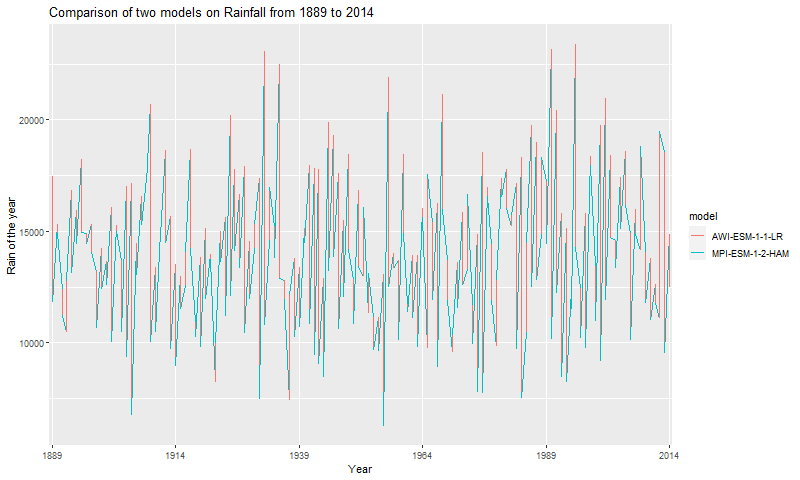

In [29]:
%%R -w 800
# To compare trendlines of two models
ggplot(df_year, aes(x = year, y = rain, color = model, group=1)) +
    geom_line() + labs(y='Rain of the year', x='Year') +
    scale_x_discrete(breaks=c(1889, 1914, 1939, 1964, 1989, 2014)) +
    ggtitle("Comparison of two models on Rainfall from 1889 to 2014")

##### 5.1.3 feather format

In [30]:
%%R
library(arrow)
library(dplyr)

In [31]:
# load in combined dataset again as df
df = pd.read_csv("figsharerainfall/combined_data.csv", nrows=2000000)

In [32]:
%%time
# Convert df to table with pandas
table = pa.Table.from_pandas(df)

CPU times: total: 328 ms
Wall time: 323 ms


In [33]:
%%time
# Write to feather format 
feather.write_feather(table, "figsharerainfall/combined.feather")

CPU times: total: 422 ms
Wall time: 192 ms


##### Simple EDA with feather format

In [34]:
%%time
%%R

start_time <- Sys.time()
r_table <- arrow::read_feather("figsharerainfall/combined.feather")
print(class(r_table))

result <- r_table %>% count(model)
end_time <- Sys.time()
print(result)
print(end_time - start_time)

[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 3 x 2
  model                n
  <chr>            <int>
1 AWI-ESM-1-1-LR  966420
2 MPI-ESM-1-2-HAM 966420
3 NorESM2-LM       67160
Time difference of 0.3254941 secs
CPU times: total: 375 ms
Wall time: 372 ms


**Observation Summary - Windows10 laptop - Dataset contains 2,000,000 rows only

|     Approach    | CPU Time  | Wall Time | file size (Mb)| Peak Memory (MiB)|
|:---------------:|:----------|:---------:|:---------: |:---------:|
| Pandas Exchange | 1min 24s  |  1min 25s |    -      |  326.72      |
| Parquet file    |  859 ms   |    967 ms |    12.98     |   326.75       |
| feather format  |  750 ms   |   515 ms  |     30.14    |  1277.00        |

Three approaches are explored here: `Pandas Exchange`,`Parquet file` and `feather format`

Both methods have its own advantages:

`Pandas exchange` - Easy and simple, the goal can be achieved by one-line code. Total wall time it took on Windows10 was around 1 min 25s. Most of the time is spent on serialization and deserialization process. 

`Parquet file` - Require more code lines but not heavy. The benefit of running time is significant. it has the benefits of predicate and projection pushdown. Since it has a hybrid model of column-based and row-based file storage properties, we were able to split the `combined_data.csv` file to selected rows. With the small size we are saving some I/O and network traffic.  

`feather format` - The file size of feather format is quite small and sufficient. It also has a faster runtime than parquet. The file space only takes about 1.2GB in memory compared to the 5.6 GB with csv we saw earlier with pandas exchange. While it may be a solution for short term exhange, parquet might be more efficient for long term storage. 
<br><br>

There is another approach called `Arrow exchange` which are similar to `Parquet file`. 
`Arrow exchange` is more suitable for short-term storage.
<br><br>

> Overall, we decided to use `Parquet file` as its the most balanced option from time, size and suitability of this project.